## Pakiety

In [16]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
import random
import warnings 
warnings.filterwarnings('ignore')
# Ustawienie ziarna w celu gwarancji reprodukowalności wyników
np.random.seed(123) 

## Wczytanie danych


In [17]:
data = pd.read_csv('clustering_R3.csv')
data = pd.DataFrame(data)

In [18]:
data.head()

,X1,X2,X3
0,152.077986,197.910402,1.095707
1,145.520487,202.128032,2.738826
2,155.441273,198.122696,0.640457
3,150.389105,206.808383,0.686486
4,149.863221,205.417527,3.555814


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
X1    1000 non-null float64
X2    1000 non-null float64
X3    1000 non-null float64
dtypes: float64(3)
memory usage: 23.6 KB


Ramka zawiera wyłącznie dane numeryczne, nie zawiera braków danych. Zatem nie wymaga czyszczenia.

In [20]:
data.describe()

,X1,X2,X3
count,1000.000000,1000.000000,1000.000000
mean,240.181036,154.937365,5.454947
std,115.556334,41.964161,4.793973
min,38.516347,87.376621,0.125057
25%,148.801776,104.853322,1.806255
50%,231.754437,151.846118,3.430892
75%,350.277958,198.367658,8.287805
max,399.930758,213.917568,24.537806


# Standaryzacja

In [21]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(data.iloc[:,[0,1,2]])
df_std = pd.DataFrame(std_scale.transform(data.iloc[:,[0,1,2]]), columns=["X1", "X2", "X3"])
df_std.head()

,X1,X2,X3
0,-0.762807,1.024554,-0.909772
1,-0.819582,1.125110,-0.566853
2,-0.733687,1.029615,-1.004782
3,-0.777429,1.236698,-0.995176
4,-0.781982,1.203537,-0.396348


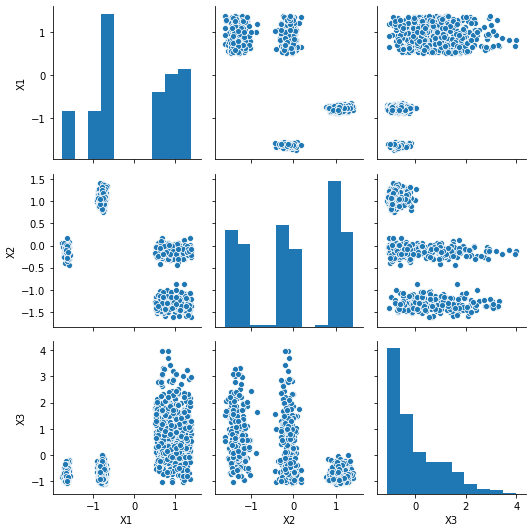

In [23]:
sns.pairplot(df_std, palette = 'dark')
plt.tight_layout()

Widać w danych pewne naturalne podziały, tym nie mniej do jednoznacznego określenia optymalnej ilości klastrów wymagane będzie zastosowanie metryk.

# Użyte metryki

### Indeks Calińskiego-Harabasza

Indeksu Calińskiego-Harabasza dla zbioru $N$ wektorów przyjmuje postać: $$\frac{tr(B(\xi_{k}))/(K-1)}{tr(W(\xi_{k}))/(N-K)},$$ gdzie $tr(X)$ oznacza ślad macierzy $X$, czyli jest sumą elementów na głównej przekątnej. 

Wielkość $tr(B(\xi_{k}))/(K-1)$ jest  miarą rozproszenia  wektorów  wokół  centroidów, do których  zostały  one  przypisane,  tym  samym  odpowiada  ona  dyspersji, minimalizowanej  podczas  działania  algorytmu minimalizowanej  podczas  działania  algorytmu K-średnich.   Dla  dobrego  podziału danych powinna ona być możliwie mała.

Wielkość $tr(W(\xi_{k}))/(N-K)$ stanowi  miarę  sumarycznego rozproszenia  centroidów klastrów wokół ogólnej średniej całego zbioru danych.  Dla dobrego podziału danych powinna ona być ona jak najmniejsza.

Oznacza to, że **dobre podziały będą charakteryzować się dużą wartością indeksu Calińskiego-Harabasza**.

*źrodło: http://www.ire.pw.edu.pl/~trubel/mpb/files/MPB_08.pdf*

### Indeks Daviesa-Bouldina

Indeks polega na wyliczeniu średniej wartości podobieństwa między grupami.

$$DB\left( K \right)=\frac{1}{K}\sum\limits_{i=1}^{K}{\left( \underset{j=1,...,K\wedge i\ne j}{\mathop{\rm max}}\,\left\{ \frac{{{w}_{i}}+{{w}_{j}}}{D\left( {{C}_{i}},{{C}_{j}} \right)} \right\} \right)}$$

$D(C_{i},C_{j})$ jest miarą odległości między grupami $C_{i}$ oraz $C_{j}$, natomiast $w_{i}$ dla $i=1,...,K$ oznaczają wagi grup.

Oczekuje się, by podobieństwo między grupami było jak najmniejsze dlatego **optymalna liczba grup minimalizuje powyższy indeks**.

*źrodło: http://books.icse.us.edu.pl/runestone/static/ai/UczenieNienadzorowane/WalidacjaUczeniaNienadzorowanego.html*

# Funkcje

In [24]:
def count_k_score(X, model, kmax, metric):
    scores = []
    k_range = range(2, kmax+1)
    for k in k_range:
        M = model(n_clusters = k)
        labels = M.fit_predict(X)
        scores.append(metric(X, labels))
    return scores, k_range

In [25]:
def plot_k(x_ticks, k_scores):
    plt.plot(x_ticks, k_scores, 'bx-')
    plt.axvline(k_scores.index(max(k_scores))+2, color = "red")
    plt.xlabel('k')
    plt.ylabel('Score')
    plt.title('Score showing the optimal k')
    plt.show()

In [26]:
def cluster_and_score(X, model, k):
    M = model(n_clusters = k)
    X['k'] = M.fit_predict(X)
    cal_har = calinski_harabasz_score(X, X['k'])
    dav_bou = davies_bouldin_score(X, X['k'])
    d = {'Indeks Calińskiego-Harabasza': [cal_har],
         'Indeks Daviesa–Bouldina': [dav_bou]}
    df = pd.DataFrame(data=d)
    return df, X

In [27]:
def plot_clusters(X):
    sns.pairplot(X, height=3, hue='k', palette = 'dark')
    plt.tight_layout()
    plt.show()

# Klasteryzacja

## 1. Agglomerative Clustering

In [28]:
from sklearn.cluster import AgglomerativeClustering

## 1.1.Wyznaczenie optymalnego k

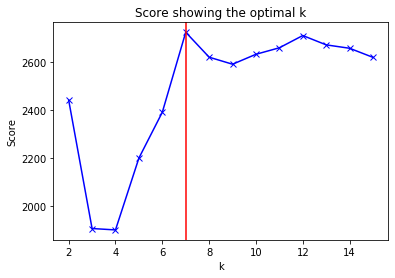

In [29]:
sil_scores1, x_ticks1 = count_k_score(df_std, AgglomerativeClustering, 15, calinski_harabasz_score)
plot_k(x_ticks1, sil_scores1)

## 1.2. Wizualizacja przypisania do klastrów

Indeks Calińskiego-Harabasza osiąga maksimum globalne przy optymalnym k. Tutaj maksimum globalne mamy dla k = 7.

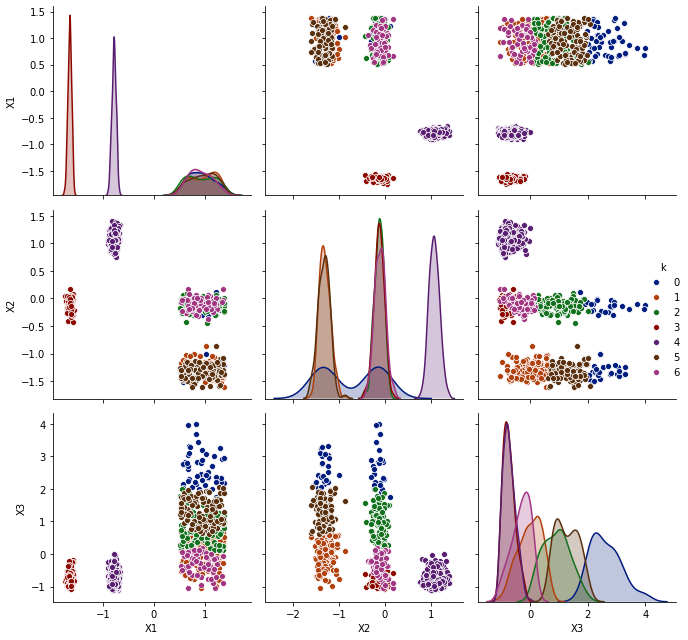

In [30]:
scores1, X1 = cluster_and_score(X = df_std, model = AgglomerativeClustering, k = 7)
plot_clusters(X1)

# 2. Birch

In [31]:
from sklearn.cluster import Birch

## 2.1.Wyznaczenie optymalnego k

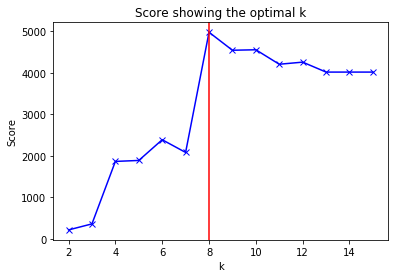

In [32]:
sil_scores2, x_ticks2 = count_k_score(X = df_std, model = Birch, kmax = 15, metric = calinski_harabasz_score)
plot_k(x_ticks2, sil_scores2)

## 2.2. Wizualizacja przypisania do klastrów

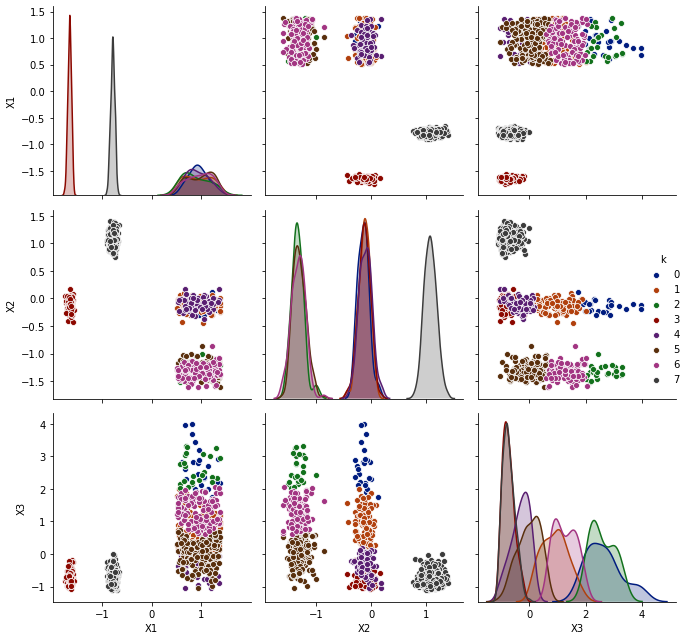

In [33]:
scores2, X2 = cluster_and_score(df_std, Birch, 8)
plot_clusters(X2)

# 3. Spectral Clustering

In [34]:
from sklearn.cluster import SpectralClustering

## 3.1. Wyznaczenie optymalnego k

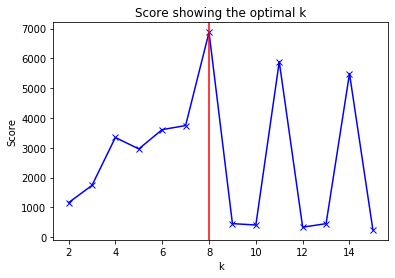

In [35]:
sil_scores3, x_ticks3 = count_k_score(X = df_std, model = SpectralClustering, kmax = 15, metric = calinski_harabasz_score)
plot_k(x_ticks3, sil_scores3)

## 3.2. Wizualizacja przypisania do klastrów

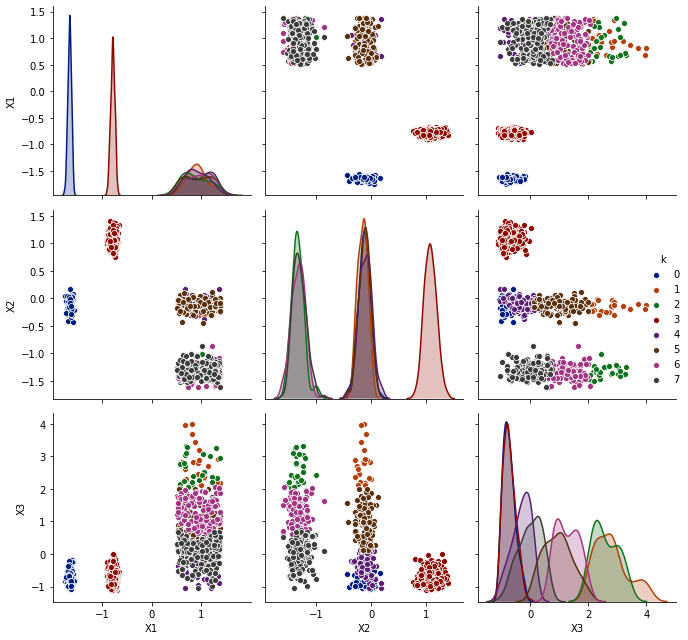

In [36]:
scores3, X3 = cluster_and_score(X = df_std, model = SpectralClustering, k = 8)
plot_clusters(X3)

# Podsumowanie
## Wyniki metod względem wybranych metryk oceny klasteryzacji.

In [37]:
results = pd.concat([scores1, scores2, scores3], axis = 0)
methods = pd.Series(["AgglomerativeClustering", "Birch", "Spectral Clustering"])
results.set_index([methods])

,Indeks Calińskiego-Harabasza,Indeks Daviesa–Bouldina
AgglomerativeClustering,5187.577686,0.391516
Birch,7109.729872,0.439636
Spectral Clustering,6554.119403,0.499218


Zgodnie z opisami metryk, ujętymi powyżej, dobre podziały będą charakteryzują się dużą wartością indeksu Calińskiego-Harabasza oraz jak najmniejszą wartością indeksu Daviesa-Bouldina. Najlepsze rezultaty względem obydwu rozważanych metryk uzyskano dla metody: **Spectral Clustering**. Tym samym, na potrzeby przeprowadzonej analizy, metoda ta może być uznana za najlepszą. Istotnym aspektem, który należy wziąć pod uwagę formułując wnioski jest fakt, że metryki są *zgodne*, tzn. porządki rezultatów poszczególnych metod, względem rozważanych miar, są jednakowe (metoda o najlepszym indeksie Calińskiego-Harabasza charakteryzuje się najlepszą wartością indeksu Daviesa-Bouldina, analogicznie dla słabszych wyników).